### Description
- Patient visits who were transferred within 24 hours
    - ICUs to non-ICUs
    - Non-ICUs to ICUs
- Prediction differences between labels at time 0 and 24hr
- Differences between predicted values at time 0 and time 24 compared to their corresponding true labels
- Within the patient visits who were transferred:
    - More in depth about those with largest differences between the predictions at 2 time points
    - and how they are related to the differences in predicted values vs. true labels
    
Inputs:
- `1_4_cohort`
- prediction outputs for 3 labels using 1_4_cohort with light gbm

Outputs:
- `1_4_cohort_test_results` test cohort (admit year 2019 and 2020) with prediction results
- `1_4_cohort_diff_full_features` 318 observations in test cohort (pred difference >= 0.3) with full features used for predictions

In [3]:
# install.packages('rms')

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘jpeg’, ‘Formula’, ‘latticeExtra’, ‘mvtnorm’, ‘TH.data’, ‘sandwich’, ‘checkmate’, ‘Hmisc’, ‘polspline’, ‘multcomp’, ‘htmlTable’




In [1]:
library(caret) # import this before glmnet to avoid rlang version problem
library(data.table)
library(tidyverse)
library(lubridate)
library(Matrix)
library(glmnet)
library(bit64)
library(pROC)
library(rms)

Loading required package: lattice

Loading required package: ggplot2

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::lift()      masks caret::lift()
x purrr::transpose() masks data.table::transpose()


Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'Matrix'


The following 

In [25]:
# directories
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
featuredir = "../../OutputTD/2_features"
modeldir4 = "../../OutputTD/3_models/1_4_cohort"
modeldir4preadmit = "../../OutputTD/3_models/1_4_cohort_24hrpreadmit"

In [4]:
# list.files(path="modeldir4", pattern="lightgbm_test_results.csv", full.names=TRUE, recursive=FALSE)
# dir(path="modeldir4") #pattern="*.csv")

In [3]:
# check folder and sub-folders
folder <- list.dirs(modeldir4) # this assumes being in the main folder, otherwise specify the path
folder
sub.folders <- folder[-1]  # comment this out if the main folder also contains the script
# script.paths <- paste(folder,"/","process.R", sep="")
# for (i in script.paths) {source(i)}

[1] "../../OutputTD/3_models/1_4_cohort"                        
[2] "../../OutputTD/3_models/1_4_cohort/death_24hr_max_label"   
[3] "../../OutputTD/3_models/1_4_cohort/death_24hr_recent_label"
[4] "../../OutputTD/3_models/1_4_cohort/first_label"

In [4]:
# sub-folders
sub.folders <- list.dirs(modeldir4)[-1]
sub.folders

[1] "../../OutputTD/3_models/1_4_cohort/death_24hr_max_label"   
[2] "../../OutputTD/3_models/1_4_cohort/death_24hr_recent_label"
[3] "../../OutputTD/3_models/1_4_cohort/first_label"

In [5]:
cohort <- read.csv(file.path(cohortdir, '1_4_cohort.csv'))
nrow(cohort)
colnames(cohort)

[1] 43980

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"

### Patient visits year and those who transferred

In [6]:
cohort_test <-  cohort %>% mutate(admit_time = ymd_hms(admit_time)) %>% 
                    mutate(adm_year = year(admit_time),
                           transfer = ifelse(death_24hr_recent_label != first_label, 1, 0)) %>% 
                    filter(adm_year > 2018)
nrow(cohort_test)
table(cohort_test$adm_year)
sum(cohort_test$transfer)

[1] 12418


 2019  2020 
10115  2303 

[1] 805

In [7]:
summary(cohort$death_24hr_recent_label)
summary(cohort_test$death_24hr_recent_label)
summary(cohort_test$acute_to_critical_label_recent)
summary(cohort_test$critical_to_acute_label_recent)

sum(cohort_test$critical_to_acute_label_recent) #526 + 279 = 805 total transfers
sum(cohort_test$acute_to_critical_label_recent)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.09468 0.00000 1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   0.104   0.000   1.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.02247 0.00000 1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.04236 0.00000 1.00000 

[1] 526

[1] 279

### Patient visits with big differences in predictions at 2 time points

In [8]:
for (f in sub.folders){
    print(f)
    out <- read.csv(paste0(f,"/","lightgbm_test_results.csv")) %>% select(pat_enc_csn_id_coded, predictions)
    cohort_test <- cohort_test %>% inner_join(out)
#     cohort_test[ , ncol(cohort_test) + 1] <- out$predictions
#     newcolname <- paste0("pred_", str_sub(f, start=-12))
    newcolname <- paste0("pred_", str_sub(f, start=36, end=-7))
    print(newcolname)
#     cohort_test <- cohort_test %>% rename(newcolname = predictions)
#     print(colnames(cohort_test))
    colnames(cohort_test)[ncol(cohort_test)] <- newcolname
}

[1] "../../OutputTD/3_models/1_4_cohort/death_24hr_max_label"


Joining, by = "pat_enc_csn_id_coded"



[1] "pred_death_24hr_max"
[1] "../../OutputTD/3_models/1_4_cohort/death_24hr_recent_label"


Joining, by = "pat_enc_csn_id_coded"



[1] "pred_death_24hr_recent"
[1] "../../OutputTD/3_models/1_4_cohort/first_label"


Joining, by = "pat_enc_csn_id_coded"



[1] "pred_first"


In [9]:
pred3 <- gather(cohort_test, labels, predictions, pred_death_24hr_max:pred_first, factor_key=TRUE)
pred2 <- pred3 %>% filter(labels != 'pred_death_24hr_max')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



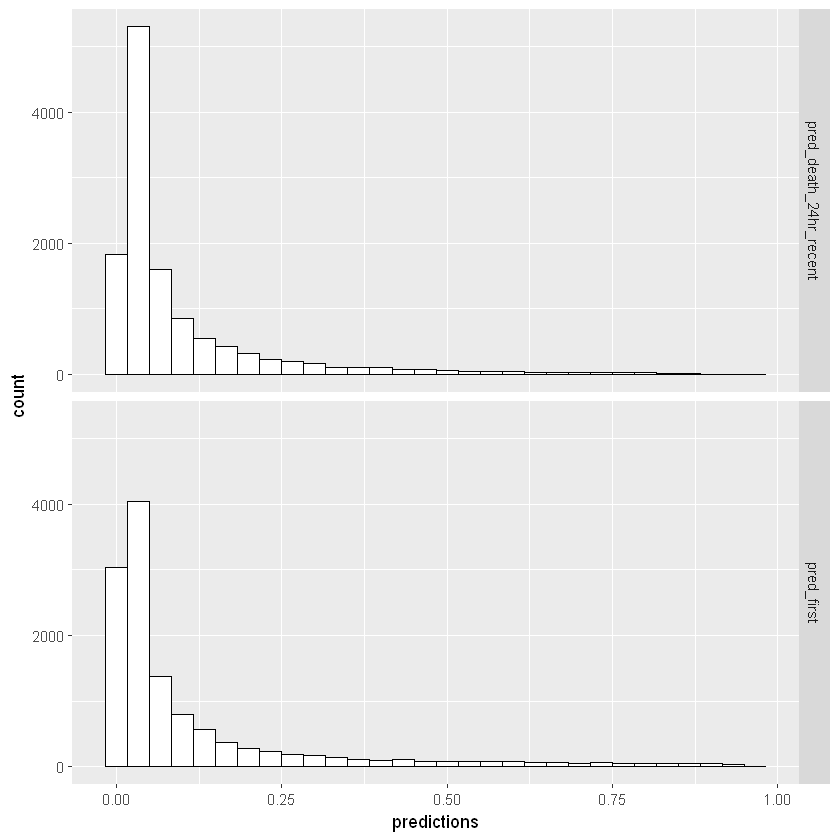

In [10]:
ggplot(pred2, aes(x = predictions)) +
  geom_histogram(fill = "white", colour = "black") +
  facet_grid(labels ~ .)

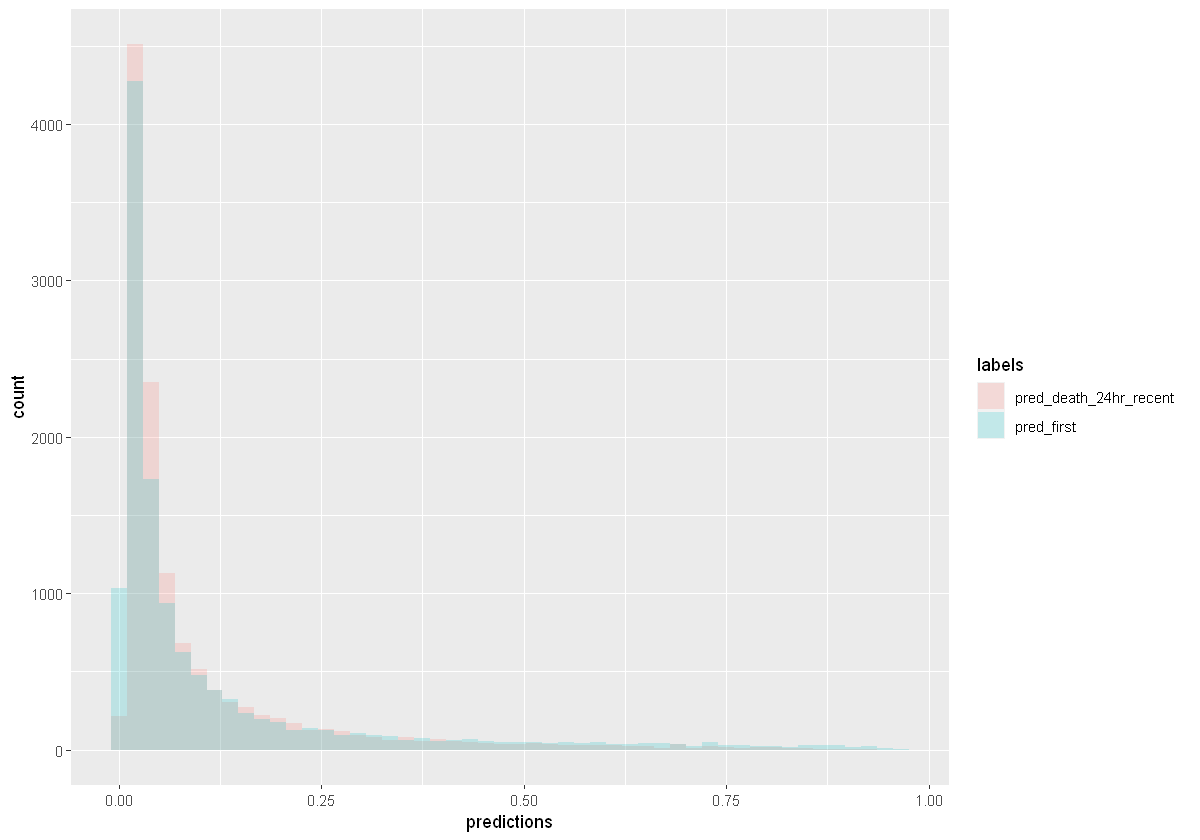

In [13]:
options(repr.plot.width=10, repr.plot.height=7)

ggplot(pred2, aes(x = predictions, fill = labels)) +         
  geom_histogram(position = "identity", alpha = 0.2, bins = 50)

In [14]:
cohort_test <- cohort_test %>% mutate(diff0_24 = round(pred_first - pred_death_24hr_recent, 2),
                                      diff0_True = round(pred_first - first_label, 2),
                                      diff24_True = round(pred_death_24hr_recent - death_24hr_max_label, 2)) %>%
               mutate(abs_diff0_24 = round(abs(diff0_24), 1))

In [15]:
nrow(cohort_test)
colnames(cohort_test)
summary(cohort_test)

[1] 12418

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "adm_year"                       
[19] "transfer"                        "pred_death_24hr_max"            
[21] "pred_death_24hr_recent"          "pred_first"                     
[23] "diff0_24"                        "diff0_True"                     
[25] "diff24_True"                     "abs_diff0_24"

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:12418       Min.   :1.313e+11    Min.   :33212811       
 Class :character   1st Qu.:1.313e+11    1st Qu.:35996148       
 Mode  :character   Median :1.313e+11    Median :39994636       
                    Mean   :1.313e+11    Mean   :40003546       
                    3rd Qu.:1.313e+11    3rd Qu.:43886508       
                    Max.   :1.313e+11    Max.   :48026130       
                                                                
   admit_time                   label_max24     label_24hr_recent
 Min.   :2019-01-01 00:03:00   Min.   :0.0000   Min.   :0.0000   
 1st Qu.:2019-04-13 00:01:30   1st Qu.:0.0000   1st Qu.:0.0000   
 Median :2019-08-04 21:50:30   Median :0.0000   Median :0.0000   
 Mean   :2019-08-08 00:19:00   Mean   :0.1512   Mean   :0.1033   
 3rd Qu.:2019-12-01 06:24:15   3rd Qu.:0.0000   3rd Qu.:0.0000   
 Max.   :2020-03-31 07:00:00   Max.   :1.0000   Max.   :1.0000   
                  

5%   10%   20%   30%   40%   50%   60%   70%   80%   90%   95% 
-0.05 -0.03 -0.01 -0.01  0.00  0.00  0.00  0.01  0.03  0.10  0.18

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.42000 -0.01000  0.00000  0.01798  0.02000  0.73000 

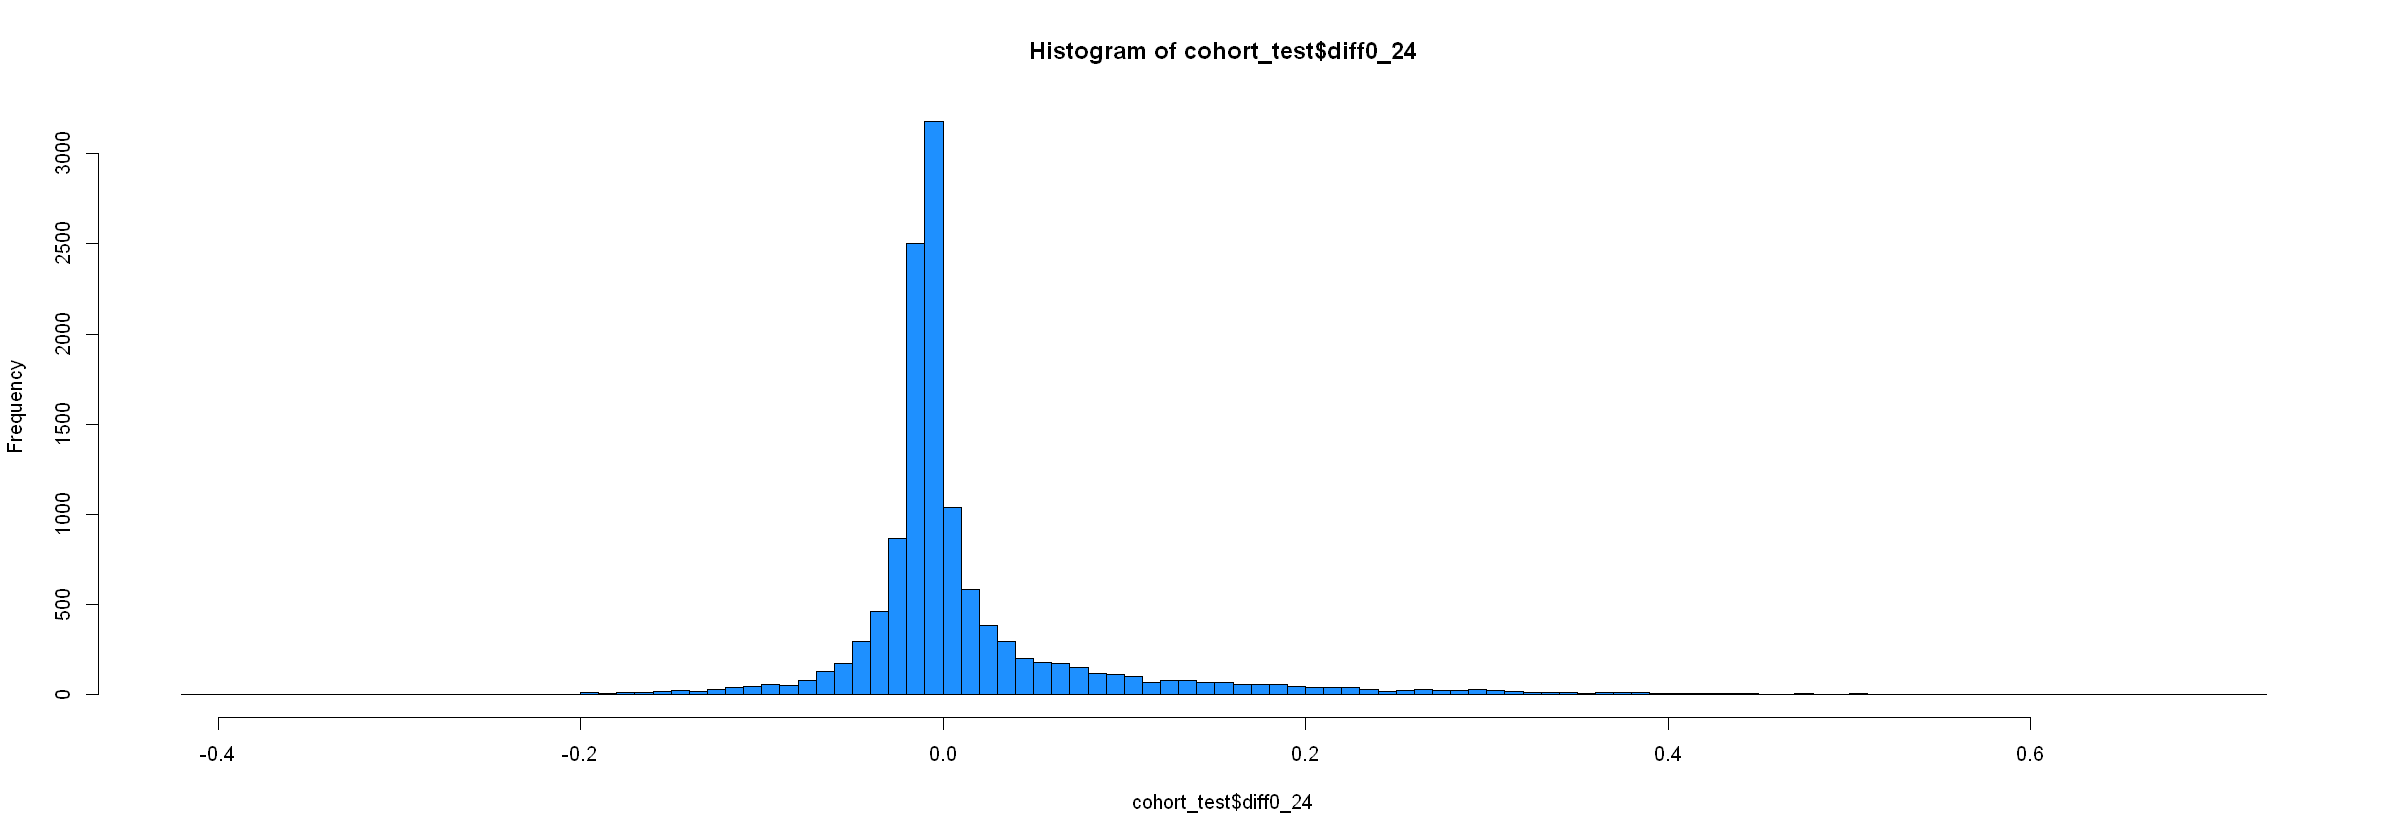

In [16]:
options(repr.plot.width=20, repr.plot.height=7)

quantile(cohort_test$diff0_24, c(.05, .1, .2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95)) 
summary(cohort_test$diff0_24)
hist(cohort_test$diff0_24, col='dodgerblue', breaks=100)

In [17]:
# diff <- cohort_test %>% arrange(-abs_diff0_24) %>% 
#         mutate(rec = 1, pround = round(abs_diff0_24, 1)) %>% 
#         group_by(pround) %>% mutate(psum = sum(rec)) %>% 
#         distinct(pround, psum) %>%
#         filter(pround > 0) #%>% mutate(cumsize = cumsum(psum)) # %>% select(-rec)

# diff$cumsize <- cumsum(diff$psum)

nrow(cohort_test %>% filter(abs_diff0_24 >= 0.3))
diff <- cohort_test %>% 
            group_by(abs_diff0_24) %>% summarise(count = n()) %>% arrange(-abs_diff0_24) %>% 
            mutate(cum_count = cumsum(count), cumperc = round(100*cum_count/nrow(cohort_test), 2)) 

diff

[1] 318

`summarise()` ungrouping output (override with `.groups` argument)



abs_diff0_24,count,cum_count,cumperc
<dbl>,<int>,<int>,<dbl>
0.7,3,3,0.02
0.6,8,11,0.09
0.5,22,33,0.27
0.4,79,112,0.90
0.3,206,318,2.56
0.2,501,819,6.60
0.1,1619,2438,19.63
0.0,9980,12418,100.00


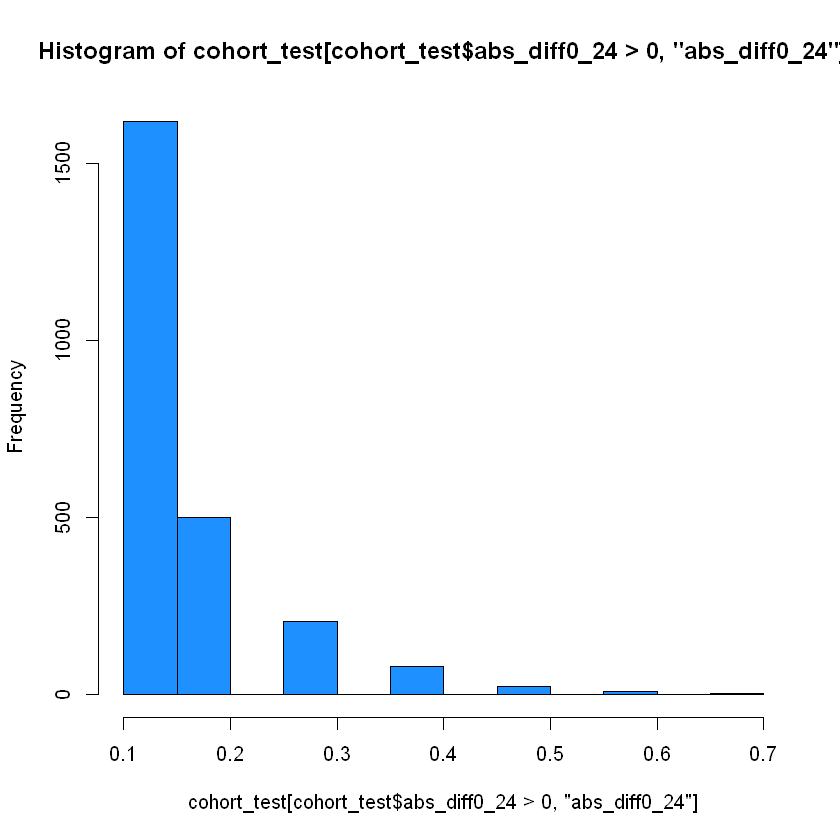

In [21]:
# threshold and size plot
options(repr.plot.width=7, repr.plot.height=7)

# absolute count
hist(cohort_test[cohort_test$abs_diff0_24 > 0, 'abs_diff0_24'], col='dodgerblue')

In [22]:
# this remained the same after updating coh4 to remove obs with labs and vitals > 24hr pre admit
diff[diff$abs_diff0_24 > 0.1,]$cum_count

[1]   3  11  33 112 318 819

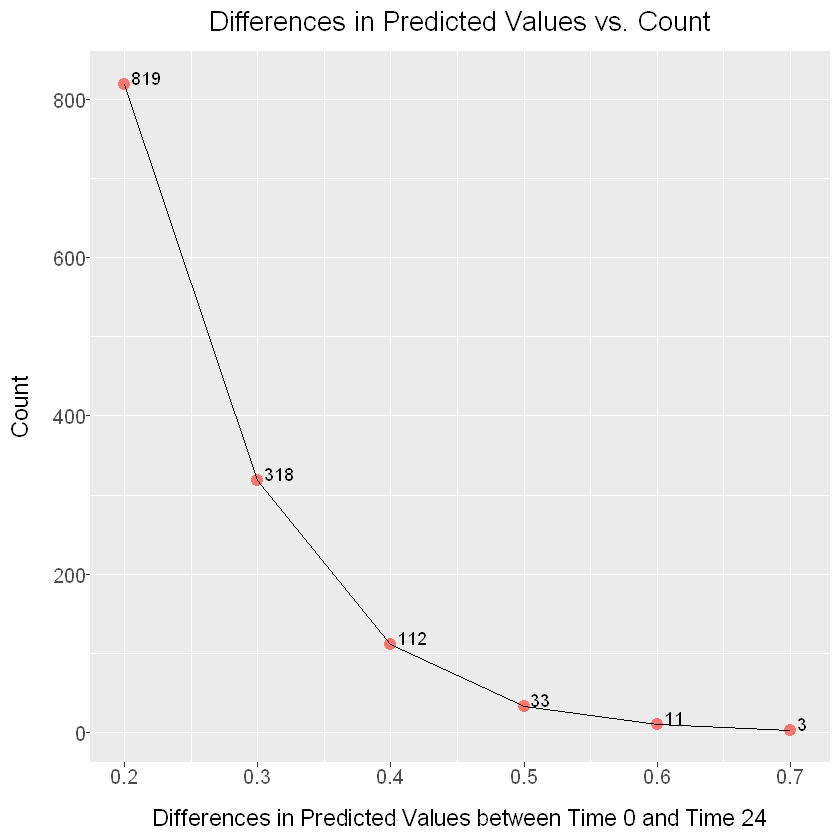

In [23]:
# cummulative count
ggplot(diff[diff$abs_diff0_24 > 0.1, ], aes(x=abs_diff0_24, y=cum_count)) + 
    geom_point(color = "#F8766D", size = 3) + geom_line() +
    geom_text(label=diff[diff$abs_diff0_24 > 0.1, ]$cum_count, hjust = 0, nudge_x = 0.005, vjust =0) + 
    labs(x="Differences in Predicted Values between Time 0 and Time 24", y="Count", 
               title = "Differences in Predicted Values vs. Count") +
    theme(axis.text=element_text(size=12),
          axis.text.x = element_text(margin=margin(0, 0, 10, 0)), #color = "red", 
          axis.text.y = element_text(margin=margin(0, 0, 0, 10)), #color = "red",
          plot.title = element_text(size=16, hjust=0.5, margin=margin(0, 0, 10, 0)),
          axis.title=element_text(size=14),
          legend.key.size = unit(1, "cm"))#, face="bold"
# ggsave("Figure - Count of Differences.png", width = 14, height = 7, dpi = 1200) 

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



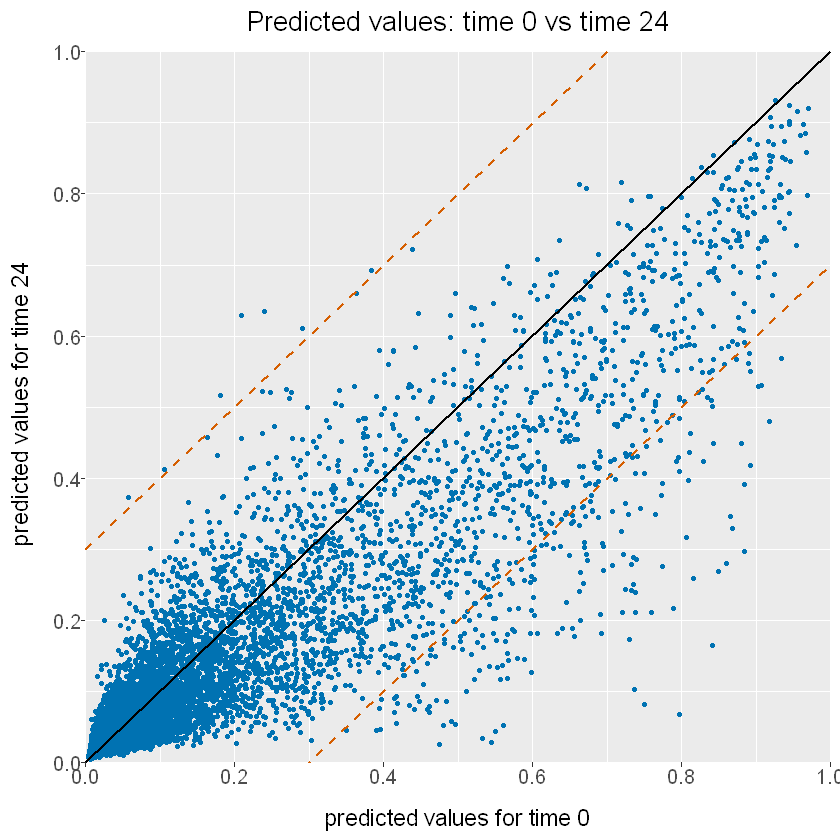

In [24]:
options(repr.plot.width=7, repr.plot.height=7)

ggplot(cohort_test, aes(x=pred_first, y=pred_death_24hr_recent)) + 
    geom_point(color = "#0072B2", size = 1) + xlim(0,1) + ylim(0,1) +
    geom_abline(intercept = 0, slope = 1, size = 0.7) +
    geom_abline(intercept = 0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    geom_abline(intercept = -0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    scale_x_continuous(name = "predicted values for time 0", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) + 
    scale_y_continuous(name = " predicted values for time 24", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) +
    theme(axis.text=element_text(size=12),
          axis.text.x = element_text(margin=margin(0, 0, 10, 0)),
          axis.text.y = element_text(margin=margin(0, 0, 0, 10)),
          plot.title = element_text(size=16, hjust=0.5, margin=margin(0, 0, 10, 0)),
          axis.title=element_text(size=14)) +
     labs(title = "Predicted values: time 0 vs time 24")


In [26]:
write.csv(cohort_test, file.path(modeldir4preadmit, "1_4_cohort_test_results.csv"), row.names=FALSE)

### Get all features used for prediction for the test cohort

In [8]:
orders5 <- read.csv(file.path(datadir, 'coh5_order_code_counts.csv'))
nrow(orders5) # should have 5730678

[1] 5730678

In [27]:
orders4 <- read.csv(file.path(datadir, 'coh4_order_code_counts.csv')) %>% 
            mutate(admit_time = ymd_hms(admit_time),
                   feature_type = ifelse(str_detect(feature_type, "Microbiology"), "Microbiology", feature_type))
nrow(orders4) # 6086852

[1] 6086852

In [30]:
values <- read.csv(file.path(featuredir, '2_7_coh4_feature_values.csv')) %>% 
                    mutate(admit_time = ymd_hms(admit_time), time = ymd_hms(time),
                           hr_before_admit = round(as.numeric(difftime(admit_time, time, unit="hours")), 1))
nrow(values) #3085046

[1] 3085046

In [31]:
colnames(orders4)
colnames(values)
colnames(cohort_test)
nrow(cohort_test)

[1] "anon_id"              "pat_enc_csn_id_coded" "admit_time"          
[4] "feature_type"         "features"             "values"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time"              "first_label"            
 [5] "death_24hr_recent_label" "death_24hr_max_label"   
 [7] "feature_type"            "features"               
 [9] "values"                  "time"                   
[11] "hr_before_admit"

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "adm_year"                       
[19] "transfer"                        "pred_death_24hr_max"            
[21] "pred_death_24hr_recent"          "pred_first"                     
[23] "diff0_24"                        "diff0_True"                     
[25] "diff24_True"                     "abs_diff0_24"

[1] 12418

In [35]:
nrow(values %>% filter(feature_type %in% c('vitals', 'labs'), hr_before_admit > 24))
nrow(values)
values <- values %>% filter(hr_before_admit <= 24 | is.na(hr_before_admit))
nrow(values)

[1] 40070

[1] 3085046

[1] 3044976

In [36]:
3085046 - 40070

[1] 3044976

In [33]:
cohort_diff <- cohort_test %>% select(anon_id, pat_enc_csn_id_coded, admit_time, 
                                      first_label, death_24hr_recent_label, death_24hr_max_label,
                                      pred_first, pred_death_24hr_recent, abs_diff0_24, diff0_True, diff24_True) %>% 
                    filter(abs_diff0_24 >= 0.3)

In [37]:
diff_cohort_orders <- left_join(cohort_diff, orders4)
diff_cohort_values <- left_join(cohort_diff, values) 
length(unique(diff_cohort_orders$pat_enc_csn_id_coded))
length(unique(diff_cohort_values$pat_enc_csn_id_coded))

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "first_label", "death_24hr_recent_label", "death_24hr_max_label")



[1] 318

[1] 318

In [38]:
nrow(diff_cohort_orders)
nrow(diff_cohort_values) # only 1 less than before 
diff_cohort_orders %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)
diff_cohort_values %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

[1] 40709

[1] 30397

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Microbiology,203
Procedures,513
Imaging,1822
Lab,6305
Meds,12397
Diagnosis,19469


`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
demo,5406
vitals,12375
labs,12616


In [39]:
diff_cohort_full_features <- full_join(diff_cohort_orders, diff_cohort_values) 
nrow(diff_cohort_full_features) # only 1 less
nrow(diff_cohort_orders) + nrow(diff_cohort_values)
length(unique(diff_cohort_full_features$pat_enc_csn_id_coded))
diff_cohort_full_features %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "first_label", "death_24hr_recent_label", "death_24hr_max_label", "pred_first", "pred_death_24hr_recent", "abs_diff0_24", "diff0_True", "diff24_True", "feature_type", "features", "values")



[1] 71106

[1] 71106

[1] 318

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Microbiology,203
Procedures,513
Imaging,1822
demo,5406
Lab,6305
vitals,12375
Meds,12397
labs,12616
Diagnosis,19469


In [40]:
write.csv(diff_cohort_full_features, file.path(modeldir4preadmit, "1_4_cohort_diff_full_features.csv"), row.names=FALSE)

### Patient visits predictions vs. truth


In [41]:
summary(cohort_test$diff0_True)
summary(cohort_test$diff24_True)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.990000  0.010000  0.030000 -0.007673  0.070000  0.930000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.99000  0.01000  0.03000 -0.05359  0.06000  0.76000 

In [42]:
diff3 <- gather(cohort_test, diffs, values, diff0_24:diff24_True, factor_key=TRUE)
diff2 <- diff3 %>% filter(diffs != 'diff0_24')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



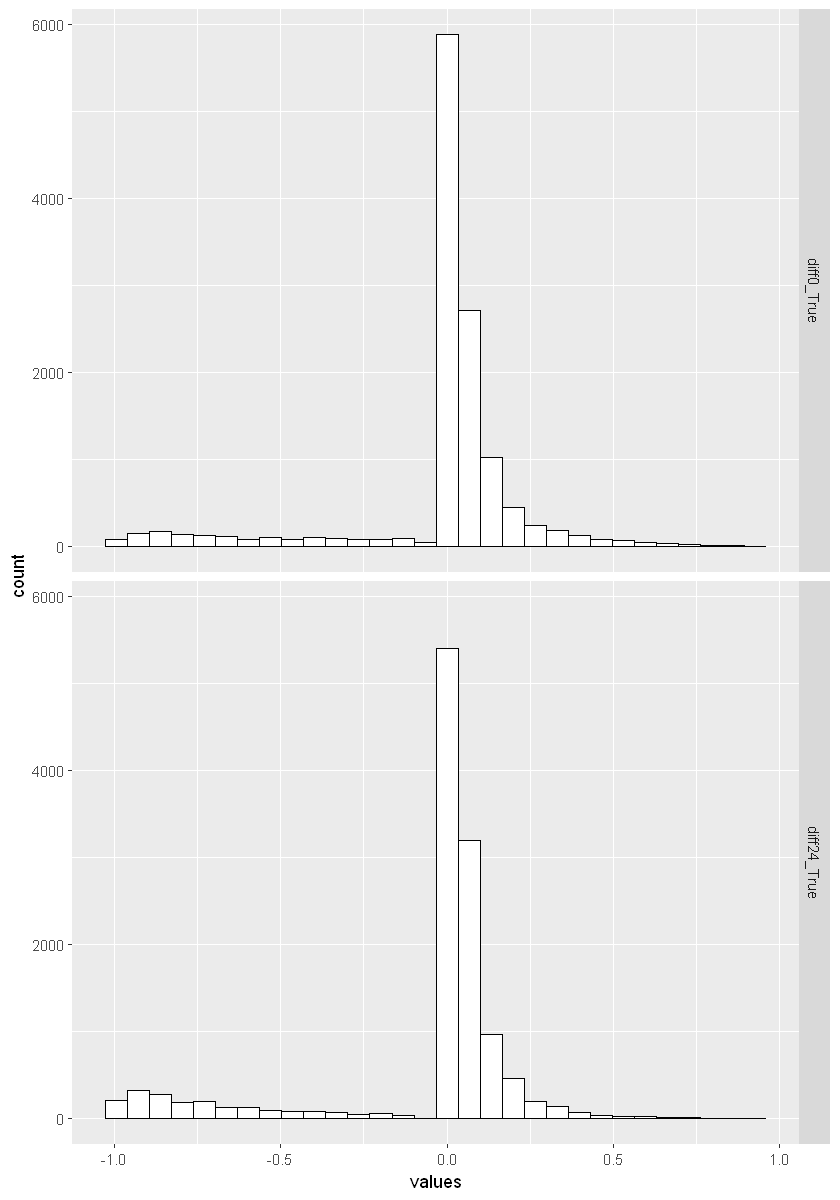

In [43]:
options(repr.plot.width=7, repr.plot.height=10)

ggplot(diff2, aes(x = values)) +
  geom_histogram(fill = "white", colour = "black") +
  facet_grid(diffs ~ .)

### 

### Check most difference first
- 0.7 or more: 3
- 0.6 or more: 11
- 0.5 or more: 33

In [44]:
diff

abs_diff0_24,count,cum_count,cumperc
<dbl>,<int>,<int>,<dbl>
0.7,3,3,0.02
0.6,8,11,0.09
0.5,22,33,0.27
0.4,79,112,0.90
0.3,206,318,2.56
0.2,501,819,6.60
0.1,1619,2438,19.63
0.0,9980,12418,100.00


### Get the full data for the cohort for exploratory analysis

In [45]:
cohort <- cohort %>% mutate(admit_time = ymd_hms(admit_time)) 

In [46]:
cohort_orders <- left_join(cohort, orders4)
cohort_values <- left_join(cohort, values)

length(unique(cohort_orders$pat_enc_csn_id_coded))
length(unique(cohort_values$pat_enc_csn_id_coded))

cohort_full <- full_join(cohort_orders, cohort_values)
nrow(cohort_full) # 9171908
nrow(cohort_orders) + nrow(cohort_values)
length(unique(cohort_full$pat_enc_csn_id_coded))
cohort_full %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "death_24hr_max_label", "death_24hr_recent_label", "first_label")



[1] 43980

[1] 43980

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded", "admit_time", "label_max24", "label_24hr_recent", "admit_label", "has_admit_label", "died_within_24hrs", "death_24hr_max_label", "death_24hr_recent_label", "first_label", "first_label_minutes_since_admit", "acute_to_critical_label_recent", "critical_to_acute_label_recent", "acute_to_critical_label_max", "critical_to_acute_label_max", "feature_type", "features", "values")



[1] 9131838

[1] 9131838

[1] 43980

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
NA,10
Microbiology,39017
Procedures,51696
Imaging,299944
demo,747660
vitals,958312
Lab,993484
labs,1339004
Meds,1868195


In [47]:
write.csv(cohort_full, file.path(featuredir, "1_4_cohort_24hrpreadmit_full_features.csv"), row.names=FALSE)

In [48]:
cohort_full %>% filter(is.na(feature_type)) # nothing available for these 10 observation
# should probably remove them from the cohort, they are all ICUs

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,...,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max,feature_type,features,values,time,hr_before_admit
<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<int>,<int>,<int>,<int>,...,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dttm>,<dbl>
JCe89272,131250899044,30124250,2018-05-05 03:51:00,0,0,0,1,0,0,...,0,0,0,0,0,NA,NA,NA,NA,NA
JCe11fd2,131232385768,24937306,2017-05-14 02:19:00,0,0,0,1,0,0,...,0,0,0,0,0,NA,NA,NA,NA,NA
JCe96772,131143463175,17524105,2015-10-22 23:48:00,0,0,0,1,0,0,...,0,0,0,0,0,NA,NA,NA,NA,NA
JCeb7da1,131244907345,28357111,2018-01-23 06:01:00,0,0,0,1,0,0,...,0,0,0,0,0,NA,NA,NA,NA,NA
JCcebf1c,131193906942,20858243,2016-08-26 06:21:00,0,0,0,1,0,0,...,0,0,0,0,0,NA,NA,NA,NA,NA
JCd6a43e,131239369230,26437382,2017-10-30 01:03:00,0,0,0,1,0,0,...,0,0,0,0,0,NA,NA,NA,NA,NA
JCe87896,131236364892,25404212,2017-08-04 23:17:00,0,0,0,1,0,0,...,0,0,0,0,0,NA,NA,NA,NA,NA
JCd31313,131179268110,18727314,2016-01-30 21:37:00,0,0,0,1,0,0,...,0,0,0,0,0,NA,NA,NA,NA,NA
JC2a20b87,131282120209,45289324,2020-01-29 20:41:00,0,0,0,1,0,0,...,0,0,0,0,0,NA,NA,NA,NA,NA


In [82]:
cohort_full %>% filter(first_label == death_24hr_recent_label) %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
cohort_full %>% filter(first_label == death_24hr_recent_label) %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% top_n(50)

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Diagnosis,2686793
Meds,1766920
labs,1273740
Lab,938854
vitals,902206
demo,705177
Imaging,283278
Procedures,48607
Microbiology,36980


`summarise()` ungrouping output (override with `.groups` argument)

Selecting by n



features,n
<chr>,<int>
Pulse,201617
RR,190327
SBP,187908
DBP,187873
Temp,134481
Glucose,48073
Hct,42455
K,42455
Na,42413


In [83]:
cohort_full %>% filter(first_label != death_24hr_recent_label) %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
cohort_full %>% filter(first_label != death_24hr_recent_label) %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% top_n(50)

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Diagnosis,147723
Meds,101275
labs,84929
vitals,76511
Lab,54630
demo,42483
Imaging,16666
Procedures,3089
Microbiology,2037


`summarise()` ungrouping output (override with `.groups` argument)

Selecting by n



features,n
<chr>,<int>
Pulse,17435
RR,17285
SBP,16914
DBP,16913
Temp,7964
Glucose,3578
K,2949
Na,2926
Hgb,2923


In [84]:
cohort_full %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
cohort_full %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% top_n(50)

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Diagnosis,2834516
Meds,1868195
labs,1358669
Lab,993484
vitals,978717
demo,747660
Imaging,299944
Procedures,51696
Microbiology,39017


`summarise()` ungrouping output (override with `.groups` argument)

Selecting by n



features,n
<chr>,<int>
Pulse,219052
RR,207612
SBP,204822
DBP,204786
Temp,142445
Glucose,51651
K,45404
Hct,45377
Na,45339


In [88]:
coh_vsglu <- cohort_full %>% filter(feature_type=='vitals' | features=="Glucose") %>%
                    mutate(pat_enc_csn_id_coded = factor(pat_enc_csn_id_coded),
                           features = factor(features),
                           hr_before_admit = round(as.numeric(difftime(admit_time, time, unit="hours")), 1)) %>%
                    group_by(pat_enc_csn_id_coded, features, hr_before_admit) %>%
                    summarise(values=mean(values, na.rm=TRUE))
                    
coh_vsglu %>% group_by(features) %>% summarise(n=n())
head(coh_vsglu)

`summarise()` regrouping output by 'pat_enc_csn_id_coded', 'features' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



features,n
<fct>,<int>
DBP,54516
Glucose,40587
Pulse,54592
RR,54201
SBP,54516
Temp,49989


pat_enc_csn_id_coded,features,hr_before_admit,values
<fct>,<fct>,<dbl>,<dbl>
131062667066,DBP,17,49.00000
131062667066,Glucose,17,149.00000
131062667066,Pulse,17,58.64286
131062667066,RR,17,19.35714
131062667066,SBP,17,134.85714
131062667066,Temp,17,37.00000


In [92]:
# 131242313490 weird obs
summary(coh_vsglu$hr_before_admit)
coh_vsglu %>% filter(hr_before_admit > 24) %>% arrange(-hr_before_admit)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    -8.00     -1.20      8.00      8.96     16.70 140156.40 

pat_enc_csn_id_coded,features,hr_before_admit,values
<fct>,<fct>,<dbl>,<dbl>
131242313490,RR,140156.4,18.00000
131090609481,DBP,203.8,83.50000
131090609481,Glucose,203.8,102.00000
131090609481,Pulse,203.8,101.00000
131090609481,RR,203.8,18.00000
131090609481,SBP,203.8,108.00000
131090609481,Temp,203.8,37.00000
131079480612,DBP,184.6,83.00000
131079480612,Pulse,184.6,98.00000


In [97]:
coh_vsglu %>% filter(hr_before_admit < 0) %>% arrange(hr_before_admit)

pat_enc_csn_id_coded,features,hr_before_admit,values
<fct>,<fct>,<dbl>,<dbl>
131130777324,DBP,-8,89
131130777324,Pulse,-8,79
131130777324,RR,-8,21
131130777324,SBP,-8,159
131176432774,DBP,-8,75
131176432774,Pulse,-8,102
131176432774,RR,-8,22
131176432774,SBP,-8,126
131220939817,DBP,-8,53


In [98]:
colnames(cohort_full)

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "feature_type"                   
[19] "features"                        "values"                         
[21] "time"

### Check for time diff for vitals and labs vs admit-time
admit_time is after time so time diff (admit_time, time) should be positive

In [116]:
coh_time <- cohort_full %>% mutate(admit_time = ymd_hms(admit_time), time = ymd_hms(time)) %>%
                    mutate(hr_before_admit = round(as.numeric(difftime(admit_time, time, unit="hours")), 1)) %>%
                    select(pat_enc_csn_id_coded, admit_time, time, hr_before_admit, features, feature_type, values)

In [117]:
summary(coh_time$hr_before_admit)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0       1       3       4       5  140140 6834522 

In [ ]:
coh_sample <- sample_n(cohort_full, 10000)

In [118]:
coh_sampletime <- coh_sample %>% mutate(admit_time = ymd_hms(admit_time), time = ymd_hms(time)) %>%
                    mutate(hr_before_admit = round(as.numeric(difftime(admit_time, time, unit="hours")), 1)) %>%
                    select(pat_enc_csn_id_coded, admit_time, time, hr_before_admit, features, feature_type, values) #filter(hr_before_admit < 0) %>% 
summary(coh_sampletime$hr_before_admit)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   1.300   2.500   4.152   4.500 170.600    7438 

In [120]:
head(coh_time %>% filter(feature_type %in% c("vitals", "labs")) %>% arrange(-hr_before_admit))

,pat_enc_csn_id_coded,admit_time,time,hr_before_admit,features,feature_type,values
,<dbl>,<dttm>,<dttm>,<dbl>,<chr>,<chr>,<dbl>
1,131242313490,2017-11-13 04:25:00,2001-11-17 23:55:40,140140.5,RR,vitals,18
2,131090609481,2015-06-25 18:48:00,2015-06-17 20:17:00,190.5,DBP,vitals,71
3,131090609481,2015-06-25 18:48:00,2015-06-17 20:17:00,190.5,Pulse,vitals,88
4,131090609481,2015-06-25 18:48:00,2015-06-17 20:17:00,190.5,RR,vitals,18
5,131090609481,2015-06-25 18:48:00,2015-06-17 20:17:00,190.5,SBP,vitals,102
6,131090609481,2015-06-25 18:48:00,2015-06-17 20:17:00,190.5,Temp,vitals,37


In [129]:
# 3 days: 3947 and 75 csn
cohort_48 <- coh_time %>% filter(hr_before_admit > 48)
nrow(cohort_48)
nrow(cohort_full)
length(unique(cohort_48$pat_enc_csn_id_coded))
length(unique(cohort_full$pat_enc_csn_id_coded))

[1] 10293

[1] 9171908

[1] 186

[1] 43980

In [137]:
# only observations could be remove, but not the entire visits/csns. remains the same number of unique csn
cohort48 <- coh_time %>% filter(hr_before_admit <= 48 | is.na(hr_before_admit))
nrow(cohort48)
length(unique(cohort48$pat_enc_csn_id_coded))

[1] 9161615

[1] 43980

In [138]:
# go back to the feature set of 2_7_coh4_features_values to remove these values and retrain the models
summary(cohort48$hr_before_admit)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0       1       3       4       4      48 6834522 

Warning message:
"`fun.y` is deprecated. Use `fun` instead."
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



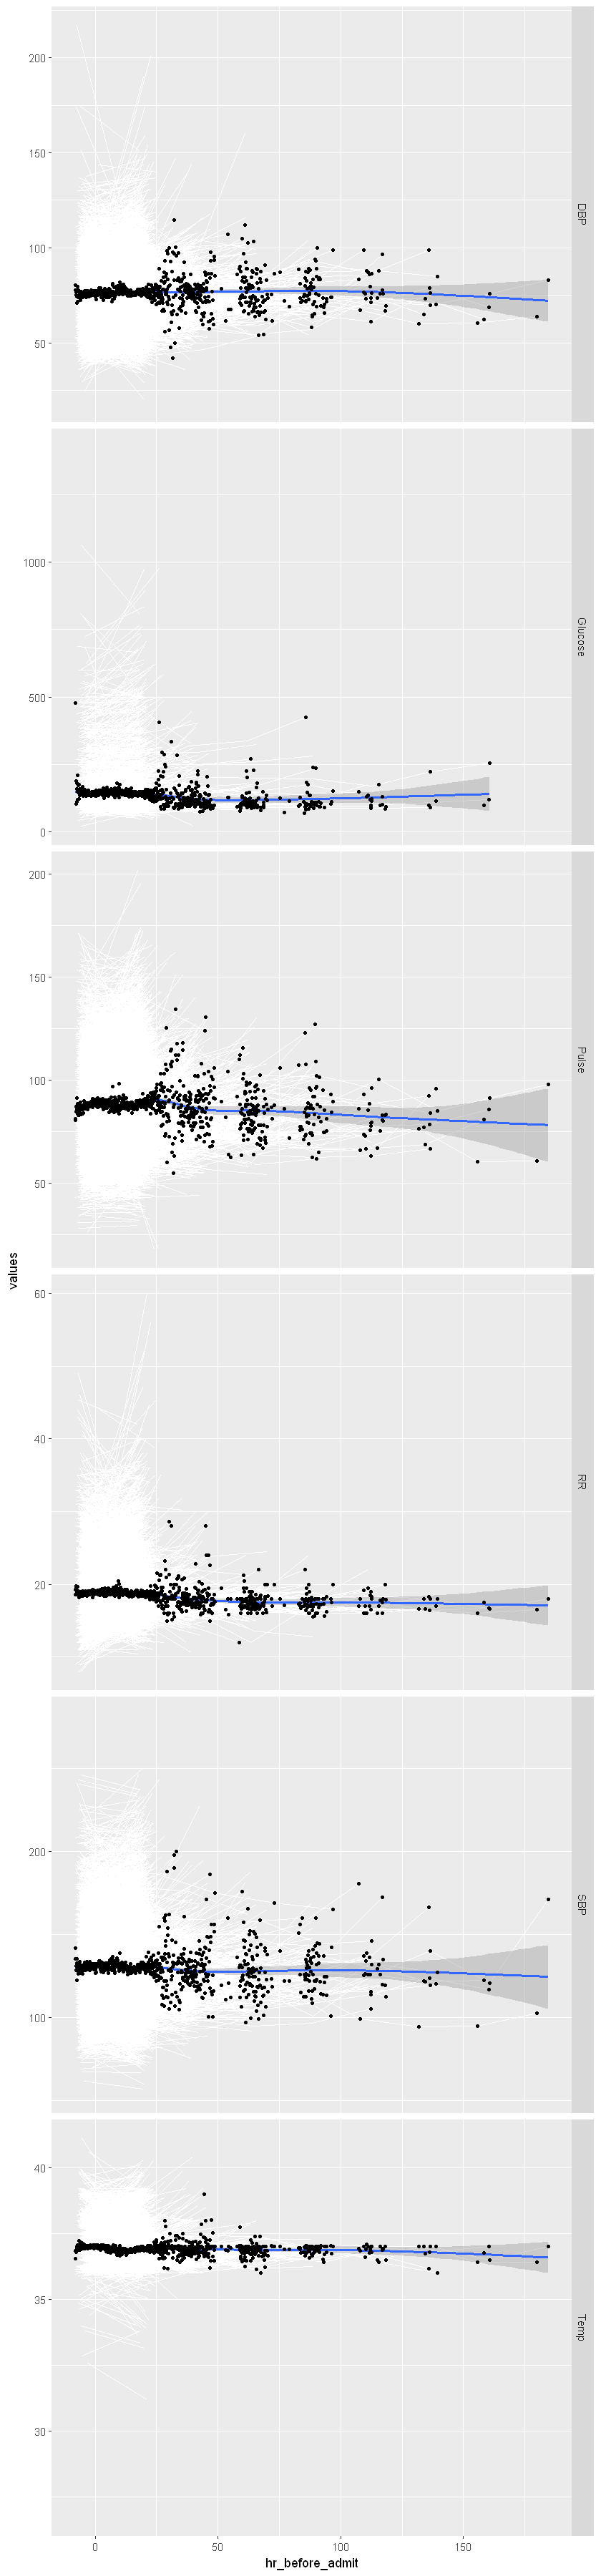

In [133]:
options(repr.plot.width=7, repr.plot.height=30)

coh_vsglu12 <- coh_vsglu %>% filter(hr_before_admit <= 200)
p <- ggplot(data = coh_vsglu12, aes(x = hr_before_admit, y = values, group = pat_enc_csn_id_coded)) + facet_grid(features ~ ., scales="free")

# use group 1 as for the whole data NOT per csn: so the smooth is not calculated separately for each csn
p + geom_line(color="white") + stat_smooth(aes(group = 1)) + stat_summary(aes(group = 1), geom = "point", size=1, fun.y = mean)

### Check AUC and PRC

[1] 0.8759954

[1] 0.6425512

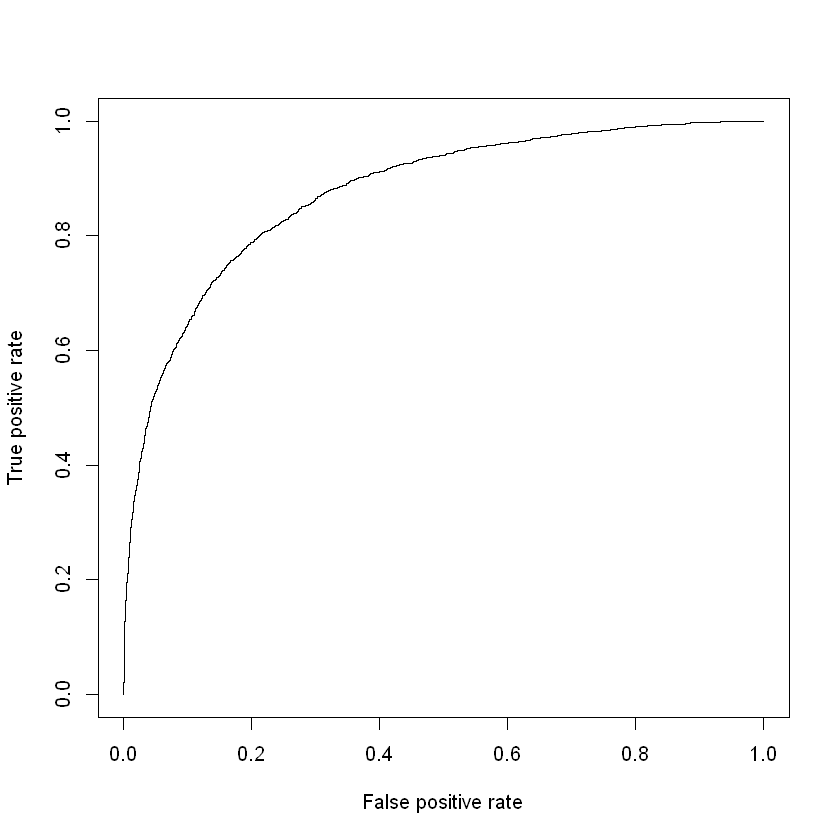

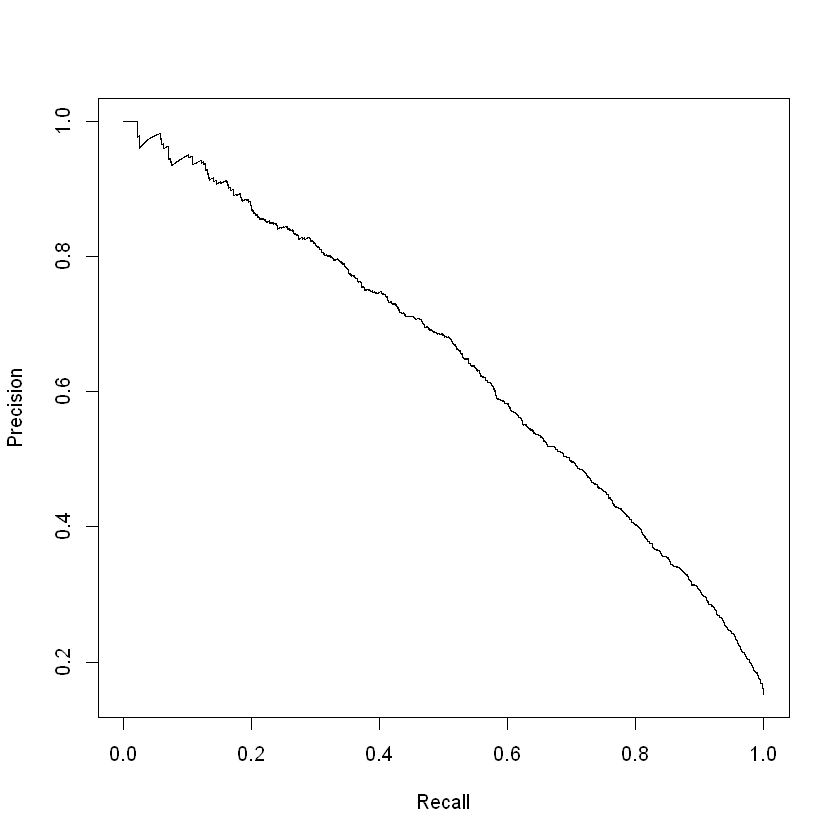

In [74]:
# get performance metrics AUC and PRC, highest level of care
options(repr.plot.width=7, repr.plot.height=7)

# pred_rocr = ROCR::prediction(cohort_test$pred_death_24hr_recent, cohort_test$death_24hr_recent_label)
pred_rocr = ROCR::prediction(cohort_test$pred_death_24hr_max, cohort_test$death_24hr_max_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc

plot(ROC.perf)
plot(PRC.perf)

[1] 0.8527461

[1] 0.4911128

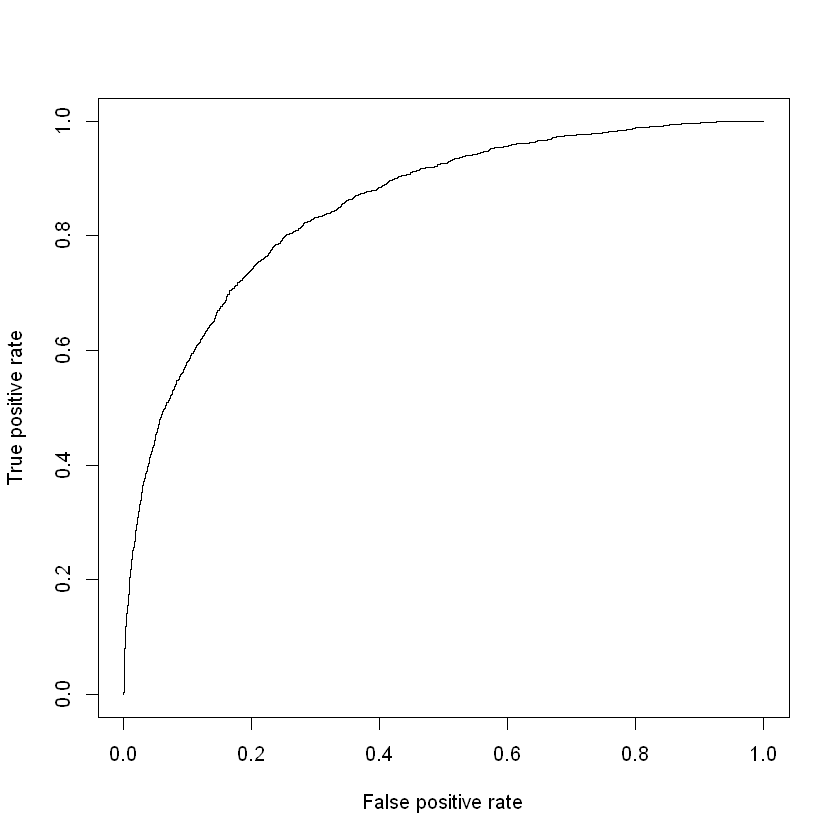

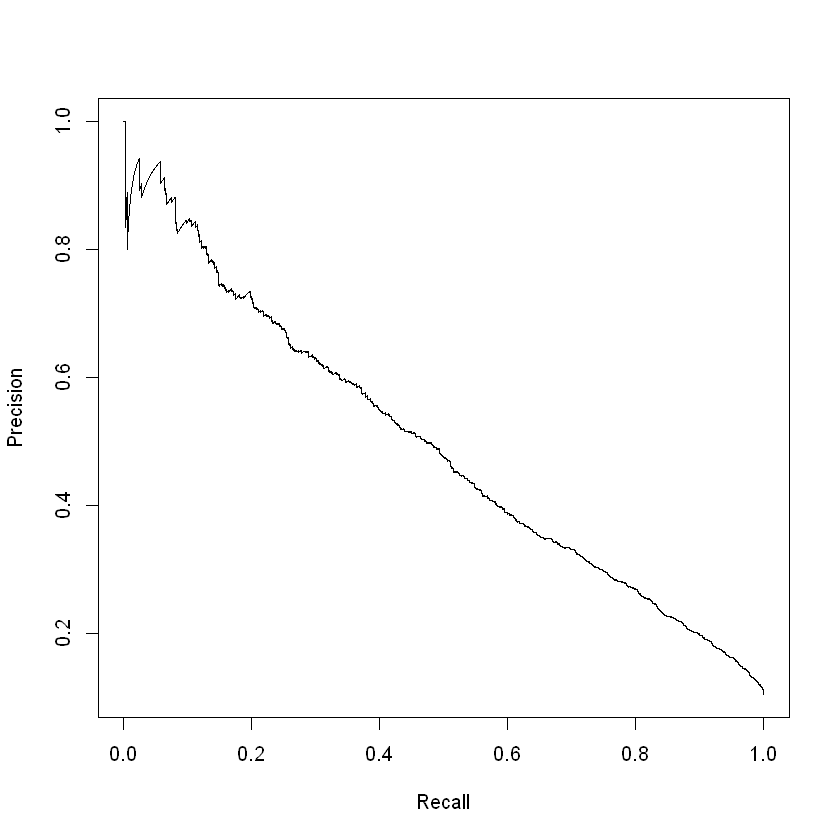

In [70]:
# get performance metrics AUC and PRC, at 24hr
options(repr.plot.width=7, repr.plot.height=7)

pred_rocr = ROCR::prediction(cohort_test$pred_death_24hr_recent, cohort_test$death_24hr_recent_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc

plot(ROC.perf)
plot(PRC.perf)

[1] 0.8513965

[1] 0.487724

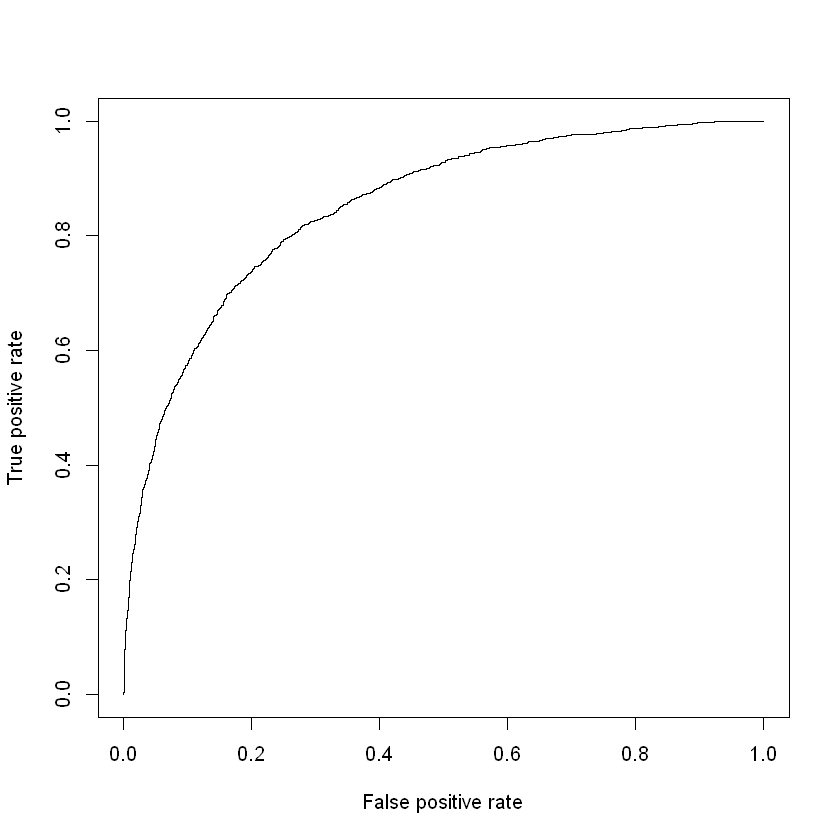

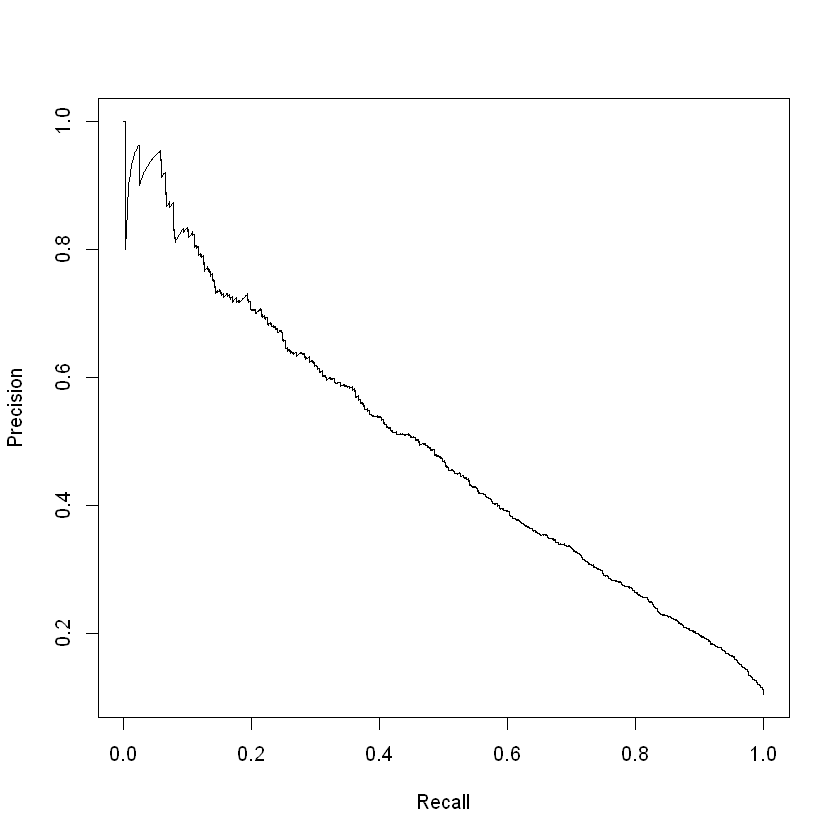

In [73]:
test2019 <- cohort_test %>% filter(adm_year==2019)
pred_rocr = ROCR::prediction(test2019$pred_death_24hr_recent, test2019$death_24hr_recent_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc

plot(ROC.perf)
plot(PRC.perf)

[1] 0.9072535

[1] 0.6422387

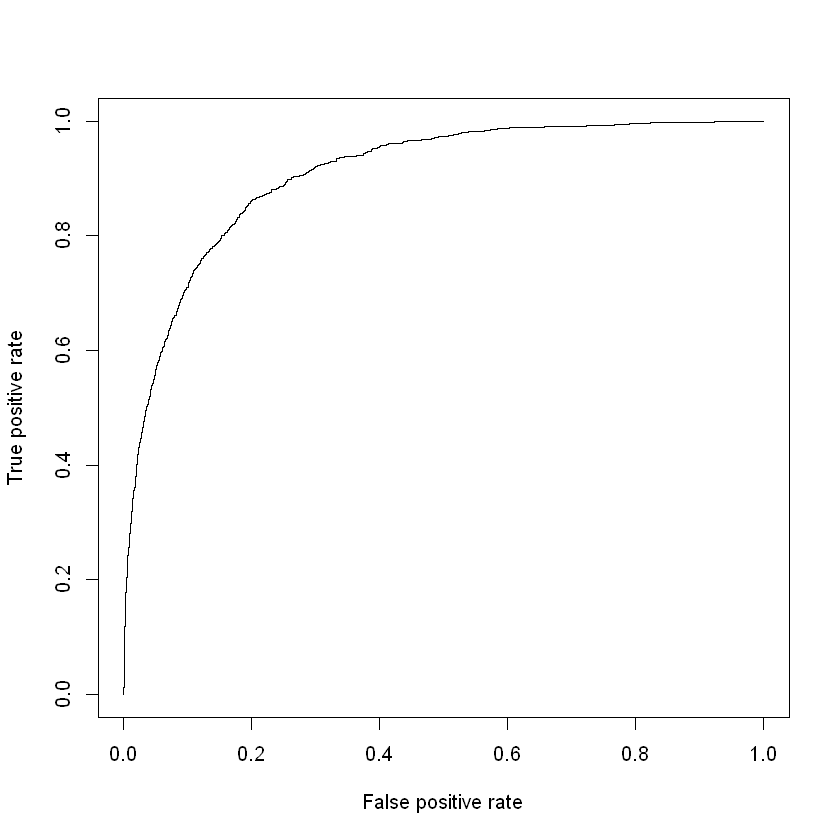

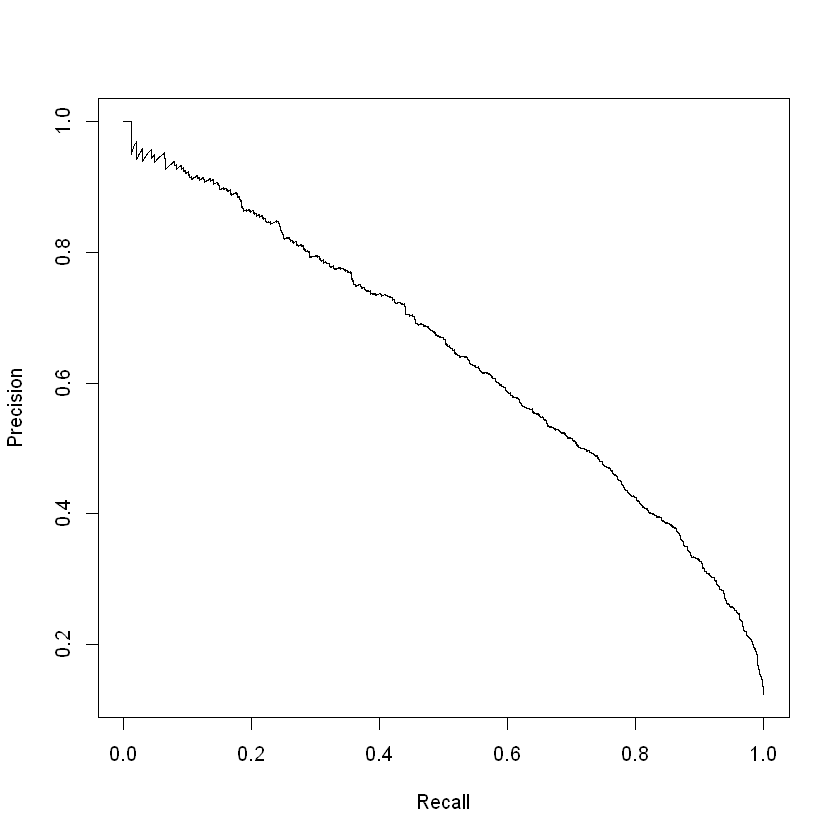

In [76]:
# get performance metrics AUC and PRC, and ACC
options(repr.plot.width=7, repr.plot.height=7)

pred_rocr = ROCR::prediction(cohort_test$pred_first, cohort_test$first_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc

plot(ROC.perf)
plot(PRC.perf)